## B cells versus T cells
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we note presence/absense changes and quantify fold changes using a T test.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
#currently pulls example data
data = load_data.load()
#data.head()

In [2]:
def check_present(row):
    bool_row = []
    for i in row:
        bool_row.append(bool(i))
    return sum(bool_row)

def check_three_of_each_type(row, cell_types=[" A_", " B_"]):
    present_in_types = []
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        data_by_type = row.loc[cells_of_type]
        in_type = check_present(data_by_type)
        three_in_type = bool(in_type > 2)
        present_in_types.append(three_in_type)
    if sum(present_in_types) == len(cell_types):
        return True
    else: return False
    
def check_presence_absence(row, cell_types=[" A_", " B_"]):
    present_in_types = {}
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        data_by_type = row.loc[cells_of_type]
        in_type = check_present(data_by_type)
        present_in_types[i] = in_type
    if 0 in list(present_in_types.values()):#absent in one type
        if present_in_types[cell_types[0]] > 2:
            return 1
        elif present_in_types[cell_types[1]]> 2:
            return 2

Here, we record which proteins are only identified in one cell type.

In [3]:
present_only_in = data.apply(check_presence_absence, axis=1).dropna()
present_only_in = data.loc[present_only_in.index]
#present_only_in

Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [4]:
indecies = data.apply(check_three_of_each_type, axis=1)
data = data[indecies]

Now we normalize across runs.

Finally, we will calculate the coeffients of variation for each protein within each of the two cell types. 

In [5]:
from scipy.stats import ttest_ind
from statistics import mean
import pandas as pd

In [6]:
def ttest_wrapper(row, cell_types = [' A_', ' B_']):
    split_row = []
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        split_row.append(row.loc[cells_of_type])
        
    tstat = ttest_ind(split_row[0],split_row[1])
    tstat = pd.Series(dict(statistic=tstat[0], pvalue=tstat[1]))
    return tstat
    
#Call ttest function
tstats = data.apply(ttest_wrapper, axis=1)
    

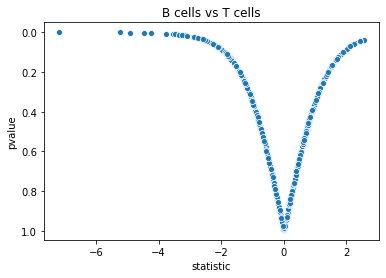

In [7]:
#graph volcano
import matplotlib.pyplot as plt
import seaborn as sns

figure = sns.scatterplot(x='statistic',y='pvalue',data=tstats)
figure.set_title("B cells vs T cells")
figure.invert_yaxis()


This shows...


In [8]:
#get higher-in-B and higher-in-T proteins
def is_altered(tscore):
    if tscore['pvalue'] < .05:
        if tscore['statistic'] > 2:
            #first type is statistically bigger
            return 1
        elif tscore['statistic'] < -2:
            #second type is statistically bigger
            return 2
        
altered = tstats.apply(is_altered, axis=1).dropna()

In [9]:
#altered.value_counts()

In [10]:
#tstats.loc[altered.index].sort_values('statistic')